In [2]:
import geopandas as gpd
import pandas as pd


import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm

# get network (2017 & 2024)

In [5]:
osm_roads_all = gpd.read_parquet("../processed_osm_files/germany_roads_2018_2024.parquet")

In [6]:
osm_roads_2024=osm_roads_all[osm_roads_all.year=="2024"].copy()

In [7]:
osm_roads_2024 = osm_roads_2024.to_crs(epsg=25832)

In [17]:
#raster.to_parquet(r"DE_Grid_ETRS89-UTM32_1km.gpkg\Zensus2022_grid_final_7053549391879339012.parquet")

# full raster (not only with )
#raster = gpd.read_parquet(r"..\..\ohsome\Gitteransatz\DE_Grid\Zensus2022_grid_final_7053549391879339012.parquet")

raster = gpd.read_file("../raster_data/Zensus2022_grid_final_7053549391879339012.gpkg")

In [19]:
raster=raster[["id","Einwohner","geometry"]].copy()

In [20]:
raster

id  Einwohner  \
0       1kmN2692E4341       21.0   
1       1kmN2692E4344       18.0   
2       1kmN2693E4340       29.0   
3       1kmN2694E4340       17.0   
4       1kmN2694E4343        9.0   
...               ...        ...   
384176  1kmN3555E4200        NaN   
384177  1kmN3555E4201        NaN   
384178  1kmN3556E4196        NaN   
384179  1kmN3556E4197        NaN   
384180  1kmN3556E4198        NaN   

                                                 geometry  
0       MULTIPOLYGON (((1142634.394 5997957.954, 11441...  
1       MULTIPOLYGON (((1147050.277 5997940.929, 11485...  
2       MULTIPOLYGON (((1141167.27 5999441.922, 114263...  
3       MULTIPOLYGON (((1141172.111 6000920.989, 11426...  
4       MULTIPOLYGON (((1145589.527 6000904.744, 11470...  
...                                                   ...  
384176  MULTIPOLYGON (((902321.335 7378578.267, 904063...  
384177  MULTIPOLYGON (((904063.338 7378623.975, 905805...  
384178  MULTIPOLYGON (((895305.159 7380138.895, 897047...  
384179  MULTIPOLYGON (((897047.472 7380186.141, 898789...  
384180  MULTIPOLYGON (((898789.804 7380233.008, 900532...  

[384181 rows x 3 columns]

In [23]:
osm_roads_all.maxspeed.value_counts(dropna=False)[:30]

maxspeed
50                  888345
None                552313
100                 223382
70                  197699
30                   90500
60                   45169
80                   28143
40                    8461
20                    2070
90                     921
DE:urban               775
10                     354
DE:rural               299
none                   224
signals                136
120                    105
5                       30
AT:rural                16
58                      14
65                      12
15                      10
DE:living_street         8
130                      7
AT:urban                 6
variable                 6
3                        5
walk                     5
60;80                    5
100;70;50                4
50;70                    4
Name: count, dtype: int64

In [29]:
osm_roads_all.highway.value_counts(dropna=False)[:30]

highway
secondary         818523
tertiary          747506
primary           404426
primary_link       35564
secondary_link     22226
tertiary_link      10837
Name: count, dtype: int64

In [27]:
osm_roads_all['complete'] = osm_roads_all['maxspeed'].fillna('None').apply(lambda x: 0 if x == 'None' else 1)
osm_roads_all

highway maxspeed maxspeed:conditional          id  \
0         tertiary     None                 None          99   
1        secondary      100                 None         100   
2        secondary       50                 None         122   
3         tertiary       50                 None         123   
4          primary       50                 None        1978   
...            ...      ...                  ...         ...   
1156966   tertiary       50                 None  1236125759   
1156967   tertiary       50                 None  1236125760   
1156968   tertiary       50                 None  1236125761   
1156969   tertiary       50                 None  1236125762   
1156970   tertiary       50                 None  1236125763   

                                                  geometry  year  complete  
0        MULTILINESTRING ((11.36617 48.17418, 11.36619 ...  2018         0  
1        MULTILINESTRING ((11.33035 48.18011, 11.33028 ...  2018         1  
2        LINESTRING (13.73065 51.03015, 13.73085 51.03005)  2018         1  
3        MULTILINESTRING ((13.74848 51.0325, 13.74845 5...  2018         1  
4        MULTILINESTRING ((9.91454 53.47043, 9.91507 53...  2018         1  
...                                                    ...   ...       ...  
1156966      LINESTRING (8.88736 51.9476, 8.88694 51.9477)  2024         1  
1156967    LINESTRING (8.88793 51.94701, 8.88797 51.94716)  2024         1  
1156968  MULTILINESTRING ((8.88811 51.94772, 8.88806 51...  2024         1  
1156969  MULTILINESTRING ((8.88795 51.94736, 8.88794 51...  2024         1  
1156970  MULTILINESTRING ((8.88797 51.94716, 8.88801 51...  2024         1  

[2039082 rows x 7 columns]

In [ ]:
# this takes a while ~2min

# Ensure both GeoDataFrames have the same CRS
#gdf_lines = osm_roads_all[::100].to_crs(25832).copy()
gdf_lines = osm_roads_all.to_crs(25832).copy()
gdf_polygons = raster.to_crs(25832).copy()

agg_pivot=pd.DataFrame()

# Reset index to access the timestamp
gdf_lines = gdf_lines.reset_index()

# **🚀 Step 1: Pre-Filter Polygons that Contain at Least One Line**
gdf_polygons_filtered = gdf_polygons.sjoin(gdf_lines, how="inner", predicate="intersects").drop_duplicates(subset=['id_left'])[['id_left', 'geometry']]

# Define the years and speed categories to consider
speed_categories = [1, 0]

# **🚀 Step 2: Filter relevant lines once**
gdf_lines_filtered = gdf_lines[gdf_lines["complete"].isin(speed_categories)]

# **🚀 Step 3: Clip all lines to polygons at once**
gdf_clipped = gdf_lines_filtered.overlay(gdf_polygons_filtered, how="intersection")

# **🚀 Step 4: Compute Lengths Efficiently**
gdf_clipped["length"] = gdf_clipped.geometry.length

# **🚀 Step 5: Aggregate by Polygon, Year, and Speed**
agg_data = gdf_clipped.groupby(["id_left", "complete"])["length"].sum().reset_index()

# **🚀 Step 6: Pivot to create year/speed columns**
agg_pivot = agg_data.pivot(index="id_left", columns=["complete"], values="length").fillna(0)

# ✅ **Convert MultiIndex to Strings for Easier Column Handling**
#agg_pivot.columns = [f"{str(col[1])}" for col in agg_pivot.columns]

agg_pivot=agg_pivot.reset_index()
#
## **🚀 Step 7: Compute Total Length & Ratios**
agg_pivot["total_length"] = agg_pivot[1] + agg_pivot[0]
agg_pivot["ratio_complete"] = agg_pivot[1] / agg_pivot["total_length"]

## **🚀 Step 8: Merge Results Back**
#gdf_polygons_res = gdf_polygons_filtered.merge(agg_pivot, left_on="id_left", right_index=True, how="left").fillna(0)


In [30]:
agg_pivot

complete        id_left           0            1  total_length  ratio_complete
0         1kmN2693E4341     0.00000  1353.550415   1353.550415        1.000000
1         1kmN2694E4341     0.00000  2121.376621   2121.376621        1.000000
2         1kmN2695E4341     0.00000  2515.611958   2515.611958        1.000000
3         1kmN2696E4337     0.00000  2109.111802   2109.111802        1.000000
4         1kmN2696E4338     0.00000   848.320898    848.320898        1.000000
...                 ...         ...          ...           ...             ...
211769       1kmN3E4471     0.00000   601.029678    601.029678        1.000000
211770       1kmN3E4472  1207.43061  1220.766667   2428.197277        0.502746
211771       1kmN3E4475     0.00000  2250.850256   2250.850256        1.000000
211772       1kmN3E4479     0.00000  2127.177671   2127.177671        1.000000
211773       1kmN3E4480     0.00000   817.961119    817.961119        1.000000

[211774 rows x 5 columns]

In [31]:
gdf_polygons_res = gdf_polygons_filtered.merge(agg_pivot, on="id_left", how="left").fillna(0)


In [32]:
gdf_polygons_res

id_left                                           geometry  \
0       1kmN2696E4341  MULTIPOLYGON (((595465.662 5247866.582, 596464...   
1       1kmN2697E4342  MULTIPOLYGON (((596451.784 5248879.585, 597450...   
2       1kmN2698E4340  MULTIPOLYGON (((594441.168 5249854.626, 595440...   
3       1kmN2699E4339  MULTIPOLYGON (((593429.458 5250842.3, 594428.3...   
4       1kmN2699E4341  MULTIPOLYGON (((595427.286 5250867.634, 596426...   
...               ...                                                ...   
211769  1kmN3545E4218  MULTIPOLYGON (((461041.029 6094973.375, 462040...   
211770  1kmN3546E4221  MULTIPOLYGON (((464024.416 6096014.094, 465023...   
211771  1kmN3548E4218  MULTIPOLYGON (((460998.819 6097973.053, 461997...   
211772  1kmN3548E4219  MULTIPOLYGON (((461997.968 6097986.655, 462997...   
211773  1kmN3549E4218  MULTIPOLYGON (((460984.748 6098972.95, 461983....   

                 0            1  total_length  ratio_complete  
0         0.000000    87.366270     87.366270        1.000000  
1         0.000000   865.267405    865.267405        1.000000  
2       213.260660  1875.227034   2088.487694        0.897888  
3       440.252371     0.000000    440.252371        0.000000  
4         0.000000  1362.070391   1362.070391        1.000000  
...            ...          ...           ...             ...  
211769    0.000000  2019.401153   2019.401153        1.000000  
211770  613.447552   173.477759    786.925312        0.220450  
211771    0.000000  1487.819498   1487.819498        1.000000  
211772  293.862271  2214.872163   2508.734434        0.882864  
211773    0.000000   492.912978    492.912978        1.000000  

[211774 rows x 6 columns]

<Axes: >

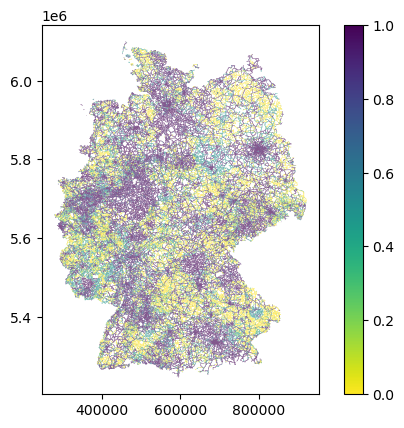

In [33]:
gdf_polygons_res.plot(column="ratio_complete", legend=True, cmap="viridis_r")

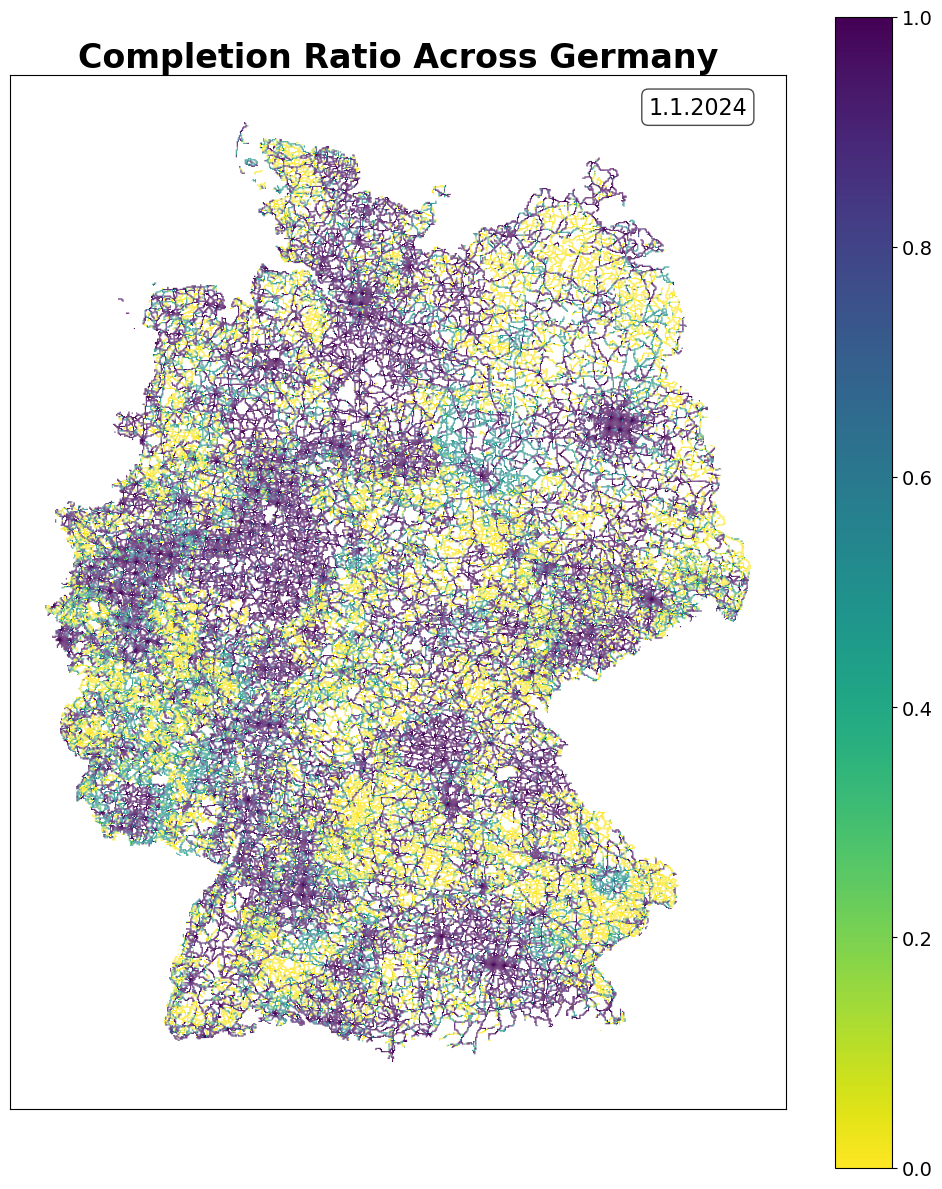

In [39]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 12))

# Plot the GeoDataFrame
plot = gdf_polygons_res.plot(
    column="ratio_complete",
    cmap="viridis_r",
    legend=True,
    ax=ax,
)

# Get the colorbar and increase tick font size
cbar = plot.get_figure().get_axes()[-1]  # colorbar axis is usually last
cbar.tick_params(labelsize=14)  # Adjust font size here

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add a title
ax.set_title("Completion Ratio Across Germany", fontsize=24, fontweight='bold')

# Add date in the top right corner (relative coordinates: x=0.95, y=0.98)
ax.text(
    0.95, 0.98, "1.1.2024",
    transform=ax.transAxes,
    fontsize=16,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_9804\2959007343.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


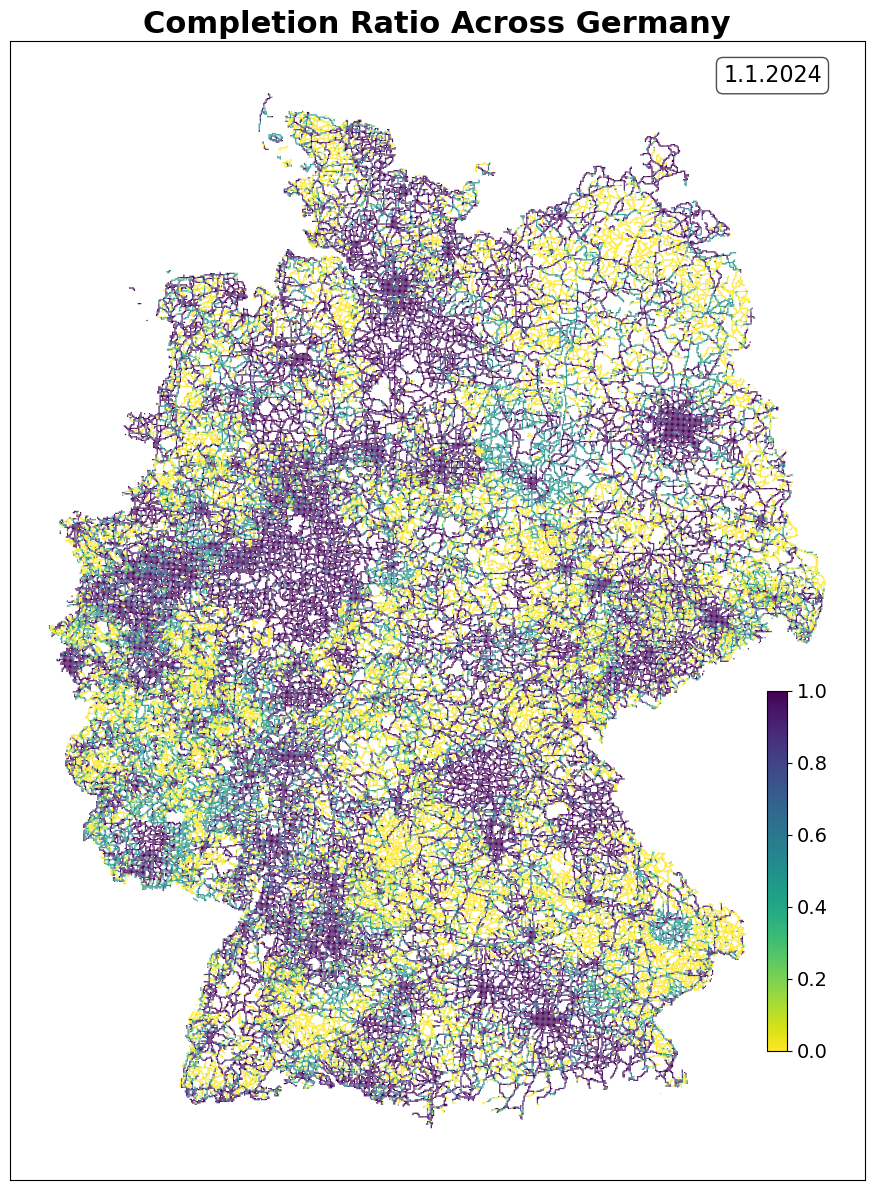

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 12))

# Plot without legend
gdf_polygons_res.plot(
    column="ratio_complete",
    cmap="viridis_r",
    ax=ax,
)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add a title
ax.set_title("Completion Ratio Across Germany", fontsize=22, fontweight='bold')

# Add date in the top right corner
ax.text(
    0.95, 0.98, "1.1.2024",
    transform=ax.transAxes,
    fontsize=16,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Create a ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=gdf_polygons_res["ratio_complete"].min(),
                            vmax=gdf_polygons_res["ratio_complete"].max())
sm = mpl.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm._A = []  # Required for colorbar

# Add the vertical colorbar manually inside the plot (bottom right)
# [left, bottom, width, height] - adjust to fit well in the corner
cbar_ax = fig.add_axes([0.83, 0.12, 0.02, 0.3])
cbar = plt.colorbar(sm, cax=cbar_ax, orientation="vertical")
cbar.ax.tick_params(labelsize=14)

# Show the plot
plt.tight_layout()
plt.show()


In [216]:
gdf_polygons_res_ew=gdf_polygons_res.merge(raster[["id","Einwohner"]], left_on="id_left",right_on="id", how="left")

In [217]:
gdf_polygons_res_ew

id_left                                           geometry  \
0       1kmN2696E4341  MULTIPOLYGON (((595465.662 5247866.582, 596464...   
1       1kmN2697E4342  MULTIPOLYGON (((596451.784 5248879.585, 597450...   
2       1kmN2698E4340  MULTIPOLYGON (((594441.168 5249854.626, 595440...   
3       1kmN2699E4339  MULTIPOLYGON (((593429.458 5250842.3, 594428.3...   
4       1kmN2699E4341  MULTIPOLYGON (((595427.286 5250867.634, 596426...   
...               ...                                                ...   
211385  1kmN3545E4218  MULTIPOLYGON (((461041.029 6094973.375, 462040...   
211386  1kmN3546E4221  MULTIPOLYGON (((464024.416 6096014.094, 465023...   
211387  1kmN3548E4218  MULTIPOLYGON (((460998.819 6097973.053, 461997...   
211388  1kmN3548E4219  MULTIPOLYGON (((461997.968 6097986.655, 462997...   
211389  1kmN3549E4218  MULTIPOLYGON (((460984.748 6098972.95, 461983....   

                no          yes  total_length  ratio_complete             id  \
0         0.000000    87.366270     87.366270        1.000000  1kmN2696E4341   
1         0.000000   865.267405    865.267405        1.000000  1kmN2697E4342   
2       213.260660  1875.227034   2088.487694        0.897888  1kmN2698E4340   
3       440.252371     0.000000    440.252371        0.000000  1kmN2699E4339   
4         0.000000  1362.070391   1362.070391        1.000000  1kmN2699E4341   
...            ...          ...           ...             ...            ...   
211385    0.000000  2019.401153   2019.401153        1.000000  1kmN3545E4218   
211386  613.447552   173.477759    786.925312        0.220450  1kmN3546E4221   
211387    0.000000  1487.819498   1487.819498        1.000000  1kmN3548E4218   
211388  293.862271  2214.882624   2508.744896        0.882865  1kmN3548E4219   
211389    0.000000   492.912978    492.912978        1.000000  1kmN3549E4218   

        Einwohner  
0             8.0  
1            68.0  
2            15.0  
3           125.0  
4          1906.0  
...           ...  
211385        NaN  
211386        NaN  
211387        NaN  
211388        NaN  
211389        NaN  

[211390 rows x 8 columns]

In [203]:
gdf_polygons_res_ew=gdf_polygons_res_ew[gdf_polygons_res_ew.Einwohner>100]

In [204]:
#gdf_polygons_res_ew

<Axes: >

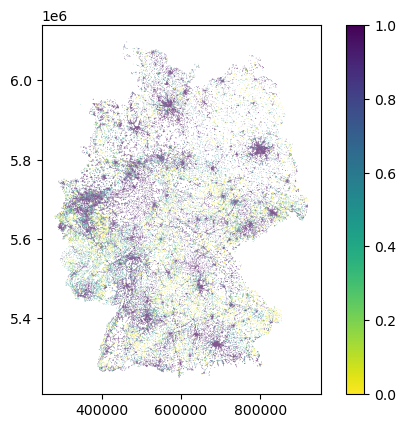

In [206]:
gdf_polygons_res_ew.plot(column="ratio_complete", legend=True, cmap="viridis_r")

In [208]:
gdf_polygons_res_ew

id_left                                           geometry  \
3       1kmN2699E4339  MULTIPOLYGON (((593429.458 5250842.3, 594428.3...   
4       1kmN2699E4341  MULTIPOLYGON (((595427.286 5250867.634, 596426...   
5       1kmN2700E4339  MULTIPOLYGON (((593416.656 5251842.64, 594415....   
6       1kmN2700E4341  MULTIPOLYGON (((595414.49 5251867.978, 596413....   
13      1kmN2702E4342  MULTIPOLYGON (((596387.818 5253881.318, 597386...   
...               ...                                                ...   
211244  1kmN3518E4285  MULTIPOLYGON (((528365.667 6068902.814, 529364...   
211246  1kmN3519E4279  MULTIPOLYGON (((522356.476 6069818.634, 523355...   
211248  1kmN3522E4294  MULTIPOLYGON (((537301.419 6073028.719, 538300...   
211253  1kmN3524E4281  MULTIPOLYGON (((524283.926 6074845.886, 525283...   
211263  1kmN3529E4251  MULTIPOLYGON (((494238.583 6079427.87, 495237....   

                 no          yes  total_length  ratio_complete             id  \
3        440.252371     0.000000    440.252371        0.000000  1kmN2699E4339   
4          0.000000  1362.070391   1362.070391        1.000000  1kmN2699E4341   
5          0.000000  3531.161307   3531.161307        1.000000  1kmN2700E4339   
6          0.000000  4104.102220   4104.102220        1.000000  1kmN2700E4341   
13         0.000000  2265.215664   2265.215664        1.000000  1kmN2702E4342   
...             ...          ...           ...             ...            ...   
211244    73.819097  3009.160568   3082.979665        0.976056  1kmN3518E4285   
211246  2021.026047     0.000000   2021.026047        0.000000  1kmN3519E4279   
211248   822.948788  1770.177746   2593.126534        0.682642  1kmN3522E4294   
211253   842.953387     0.000000    842.953387        0.000000  1kmN3524E4281   
211263  1374.828466  1341.945132   2716.773599        0.493948  1kmN3529E4251   

        Einwohner  
3           125.0  
4          1906.0  
5           321.0  
6           666.0  
13          128.0  
...           ...  
211244      374.0  
211246      137.0  
211248      118.0  
211253      142.0  
211263      155.0  

[79087 rows x 8 columns]

<Axes: >

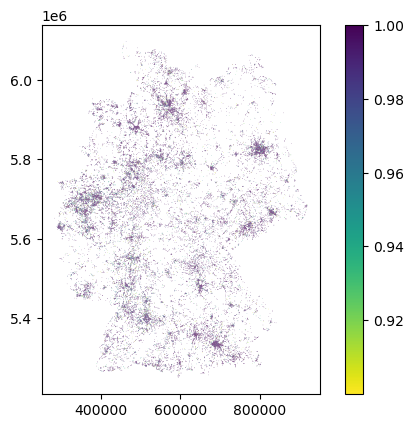

In [213]:
gdf_polygons_res_ew[gdf_polygons_res_ew.ratio_complete>0.90].plot(column="ratio_complete", legend=True, cmap="viridis_r")

In [219]:
gdf_polygons_res_ew[gdf_polygons_res_ew.ratio_complete>0.90].Einwohner.sum()

np.float64(41640756.0)